In [31]:
# hide
%reload_ext autoreload
%autoreload 2

In [32]:
from dataFunction import *
# import diffprivlib.models as dp
import numpy as np
import copy
from make_logreg_data import *
import random
import tensorflow as tf
from FL_utils import *
from HE_functions import *
from dataFunction import *
from typing import Generator
import tenseal as ts
from lrClass import LR
from simulationDataUtils import *
import seaborn as sns
from sklearn.linear_model import LinearRegression

random.seed(11007303)
np.random.seed(2021)

In [40]:
EPOCHS = 80
poly_mod_degree = 4096
coeff_mod_bit_sizes = [40, 20, 40]

# create TenSEALContext
ctx_eval = ts.context(ts.SCHEME_TYPE.CKKS, poly_mod_degree, -1, coeff_mod_bit_sizes)

# scale of ciphertext to use
ctx_eval.global_scale = 2 ** 20

# this key is needed for doing dot-product operations
ctx_eval.generate_galois_keys()

In [10]:
cleveland = "processed.cleveland.data"
switzerland = "processed.switzerland.data"
va = "processed.va.data"
hungarian = "reprocessed.hungarian.data"
cleveland_df, switzerland_df, va_df, hungarian_df = import_data(cleveland, switzerland, va, hungarian)

df_dict ={
    'Cleveland': cleveland_df,
    # 'Switzerland': switzerland_df,
    'VA Long Beach': va_df,
    'Hungary': hungarian_df        
    }

In [76]:
clients = []

for i in list(df_dict.keys()):
    df = df_dict.get(i)
    location_data = new_df(df)
    y = location_data.HeartDisease
    location_data = location_data.drop(columns="HeartDisease")

    numeric_feature_names = ['Age', 'MaxHR', 'RestingBP',  'Cholesterol', 'Oldpeak']
    for j in numeric_feature_names:
        if location_data[j].std() != 0: 
            location_data[j] = (location_data[j] - location_data[j].mean()) / location_data[j].std()
    x = location_data
    glob_model = LR(len(x.columns))
    client_model = copy.deepcopy(glob_model)
    lr = 3
    lr_decay = 1
    clients.append(Client(i, x, y, client_model, lr, torch.nn.BCELoss(), None))
cat_feat = ['ChestPainType', 'RestingECG', 'ST_Slope']
for i in clients:
    i.make_dummies(cat_feat)
val_x, val_y = make_validation_sets(clients)

best_epoch, best_acc, model_dict, final_results = FL_proces(clients, val_x, val_y, ctx_eval, glob_model, 100)
print('Best model, iter: {}, acc: {}'.format(best_epoch, best_acc))  



Best model, iter: 92, acc: 0.8199999928474426


In [79]:
clients = []

for i in list(df_dict.keys()):
    df = df_dict.get(i)
    location_data = new_df(df)
    y = location_data.HeartDisease
    location_data = location_data.drop(columns="HeartDisease")

    numeric_feature_names = ['Age', 'MaxHR', 'RestingBP',  'Cholesterol', 'Oldpeak']
    for j in numeric_feature_names:
        if location_data[j].std() != 0: 
            location_data[j] = (location_data[j] - location_data[j].mean()) / location_data[j].std()
    x = location_data
    glob_model = LR(len(x.columns))
    client_model = copy.deepcopy(glob_model)
    lr = 3
    lr_decay = 1
    clients.append(Client(i, x, y, client_model, lr, torch.nn.BCELoss(), None))
cat_feat = ['ChestPainType', 'RestingECG', 'ST_Slope']
for i in clients:
    i.make_dummies(cat_feat)
val_x, val_y = make_validation_sets(clients)

best_epoch, best_acc, model_dict, final_results = FL_proces(clients, val_x, val_y, ctx_eval, glob_model, 1000)
print('Best model, iter: {}, acc: {}'.format(best_epoch, best_acc))  



Best model, iter: 202, acc: 0.8066666722297668


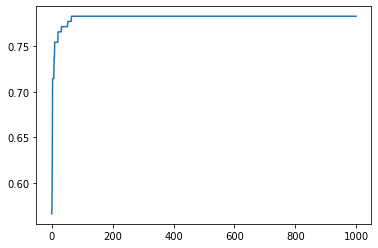

In [121]:
plt.plot(final_results.best_acc)
plt.show()

In [83]:
# for i in clients:
#     # print(i.X.Oldpeak)
#     xy = pd.concat([i.X, i.y], axis=1)
#     plt.figure(figsize=(12,10))
#     sns.heatmap(xy.corr(),annot=True,cmap="magma",fmt='.2f')
#     # print(xy)

In [134]:
df_dict_S ={
    'Cleveland': cleveland_df,
    'Switzerland': switzerland_df,
    'VA Long Beach': va_df,
    'Hungary': hungarian_df        
    }
clients = []

for i in list(df_dict_S.keys()):
    df = df_dict_S.get(i)
    location_data = new_df(df)
    y = location_data.HeartDisease
    location_data = location_data.drop(columns="HeartDisease")

    numeric_feature_names = ['Age', 'MaxHR', 'RestingBP',  'Oldpeak']
    for j in numeric_feature_names:
        if location_data[j].std() != 0: 
            location_data[j] = (location_data[j] - location_data[j].mean()) / location_data[j].std()
    x = location_data
    glob_model = LR(len(x.columns))
    client_model = copy.deepcopy(glob_model)
    lr = 3
    lr_decay = 1
    clients.append(Client(i, x, y, client_model, lr, torch.nn.BCELoss(), None))
cat_bin_features = ['Sex', 'ChestPainType',  'FastingBS', 'RestingECG','ExerciseAngina', 'ST_Slope']
KL = KL_matrices_disc_cont(clients, cat_bin_features, numeric_feature_names)

cat_feat = ['ChestPainType', 'RestingECG', 'ST_Slope']
for i in clients:
    i.make_dummies(cat_feat)
val_x, val_y = make_validation_sets(clients)

best_epoch, best_acc, model_dict, final_results, net_best = FL_proces(clients, val_x, val_y, ctx_eval, glob_model, 1000)
print(df_dict_S.keys())
print(clients[0].X.columns)
print(KL)
print('Best model, iter: {}, acc: {}'.format(best_epoch, best_acc))  


KeyboardInterrupt: 

In [133]:
glob_model.load_state_dict(model_dict)
y_pred = glob_model(val_x).detach().numpy()
y_test = val_y


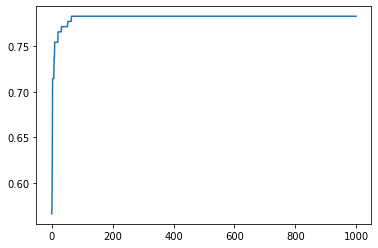

In [122]:
plt.plot(final_results.best_acc)
plt.show()

In [127]:
# Plot predicted vs test!

import plotly.graph_objects as go
 
fig = go.Figure()
 
 
fig.add_trace(go.Scatter(x=np.arange(0,len(y_test)), y=y_test,
                    mode='markers+lines',
                    name='Test'))
fig.add_trace(go.Scatter(x=np.arange(0,len(y_test)), y=y_pred,
                    mode='markers',
                    name='Pred'))

In [132]:
glob_model(val_x).detach().numpy()

array([[0.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [1.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],